In [1]:
import os
import numpy as np
import copy
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits
import galsim
import jiffy

scale = 0.2 # arcseconds
gain = 1.0

noise_var = 3.0e-10
data_topdir = "./small_shapenoise"

In [2]:
def load_footprint(ifield, igal):
    infile = os.path.join(data_topdir, "control/ground/constant/segments/seg_{:0>3}.h5".format(ifield))
    print "Reading footprints from {:s}".format(infile)
    hfile = h5py.File(infile, 'r')
    img = hfile['Footprints/seg{:d}/lsst/r/epoch_0/image'.format(igal)][...]
    noise_var = hfile['Footprints/seg{:d}/lsst/r/epoch_0/noise'.format(igal)][...]
    hfile.close()
    return img, noise_var

def apply_shear(e, g):
    return (e + g) / (1.0 + g.conjugate() * e)

def get_truths(ifield, igal):
    """
    Get the true parameter values
    """
    topdir = os.path.join(data_topdir, "control/ground/constant")
    infile = os.path.join(topdir, 
                          "epoch_catalog-{0:0>3}-0.fits".format(ifield))
    print "Reading catalog from {:s}".format(infile)
    hdulist = fits.open(infile)
    tbdata = hdulist[1].data
    print tbdata
    shears = np.array([tbdata.field('g1')[0], tbdata.field('g2')[0]])
    # Convert offsets in the truth catalog from pixels to arcseconds 
    # (which are the units expected by the galsim shift() method)
    gal_params = np.array([tbdata.field('dx')[igal], tbdata.field('dy')[igal]]) * scale
    e_int = np.array([tbdata.field('gal_e1')[igal], tbdata.field('gal_e2')[igal]])
    print "e:", tbdata.field('gal_e1')[igal], e_int[0], ' // ', tbdata.field('gal_e2')[igal], e_int[1]
    print "shear:", shears

    e_int_cmplx = e_int[0] + 1j * e_int[1]
    g_cmplx = shears[0] + 1j * shears[1]
    e_sh = apply_shear(e_int_cmplx, g_cmplx)
    print "e_sh:", e_sh
    return shears, gal_params, e_int, np.array([e_sh.real, e_sh.imag])

Reading footprints from ./small_shapenoise/control/ground/constant/segments/seg_000.h5
Reading catalog from ./small_shapenoise/control/ground/constant/epoch_catalog-000-0.fits
[ (0,  24.5,  24.5,  0.,  0.,  0.,  0.,  0.6,  0.00280893, -0.08219063,  0.19704378, -0.30702105)]
e: 0.197043784622 0.197043784622  //  -0.307021047543 -0.307021047543
shear: [ 0.00280893 -0.08219063]
e_sh: (0.189114865175-0.382253870317j)


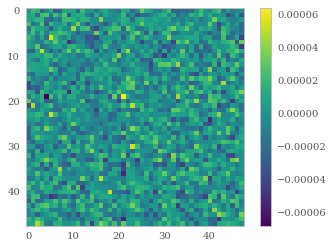

In [3]:
ifield = 0
igal = 0

img, meas_noise_var = load_footprint(ifield, igal)
true_shears, true_params, e_int, e_sh = get_truths(ifield, igal)
# -----
rstr = jiffy.Roaster("jiffy_bt1.yaml")
rstr.import_data(img, noise_var, scale=scale, gain=gain)
rstr.src_models[0].params[0].dx = true_params[0]
rstr.src_models[0].params[0].dy = true_params[1]
# rstr.src_models[0].params[0].e1 = e_int[0]
# rstr.src_models[0].params[0].e2 = e_int[1]
rstr.src_models[0].set_params(e_sh)
# print rstr.src_models[0].params
# -----
model = rstr._get_model_image()
plt.imshow(rstr.data - model.array)
plt.colorbar()

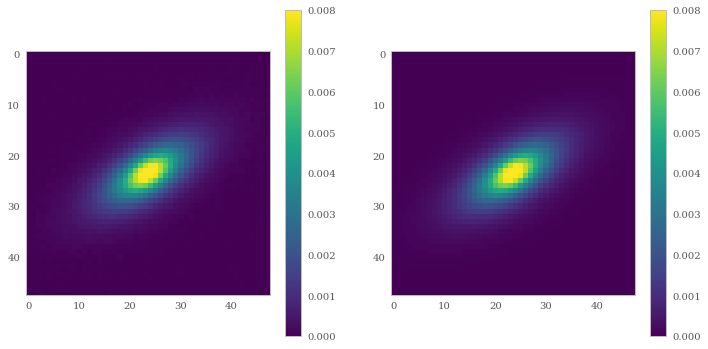

In [4]:
vmin=0.0
vmax=0.008

fig = plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.imshow(rstr.data, interpolation='none', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(model.array, interpolation='none', vmin=vmin, vmax=vmax)
plt.colorbar()